In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from utils import *

# Import data

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
%%time
# import data
data = import_data()

# train-test-validation split
train_iter, valid_iter, test_iter, voc_size, pad_idx = train_test_val_split(data,
                                                                            device,
                                                                            batch_size=512)

# Creating the embedding matrix
embedding = torch.nn.Embedding(voc_size, 16)

dataset initializing start
Tokenizing the data...


/Users/janoschjungo/Documents/ETH/MSc 3rd semester/Deep Learning/Project/dataloader.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["len"] = data.iloc[:, 0].apply(lambda x : len(self.tokenize(x)))


Length of the data :  29544
0
review       [[CLS], one, of, the, many, silent, comedies, ...
sentiment                                                    0
len                                                        186
Name: 46539, dtype: object


100%|██████████| 2955/2955 [00:00<00:00, 39542.90it/s]


dataset initializing done
Vocabulary Size :  23050
CPU times: user 2min 15s, sys: 857 ms, total: 2min 15s
Wall time: 2min 16s


In [5]:
# check imbalance
check_imbalance(train_iter, name='train set')
check_imbalance(valid_iter, name='val set')
check_imbalance(test_iter, name='test set')

Positive labels ratio (train set): 0.5052253014596996
Positive labels ratio (val set): 0.4949221394719025
Positive labels ratio (test set): 0.4910321489001692


# Training parent models

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


In [23]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, device, lr=2e-4):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch='unrestricted',
                    clip=1,
                    device=device,
                    verbose=False)

    # save model
    name = f'parallel_training/model{model_name}_IMDB_256'
    save_model(model, name=name)

    # save history
    name = f'parallel_training/history_model{model_name}_IMDB_256'
    save_history(history, name=name)

    return model

In [24]:
LEARNING_RATE = 2e-4

In [25]:
%%time
# train parent model A
modelA = train_early_stopping(model_name='A',
                              train_iter=train_iter,
                              valid_iter=valid_iter,
                              device=device,
                              lr=LEARNING_RATE)

  0%|          | 0/1000000 [00:00<?, ?it/s]/var/folders/tq/31s58g8x49x32phm81cky_s40000gn/T/ipykernel_72606/2166890979.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
/Users/janoschjungo/Documents/ETH/MSc 3rd semester/Deep Learning/Project/utils.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
  0%|          | 2/1000000 [00:47<6531:20:50, 23.51s/it]

KeyboardInterrupt



  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
100%|██████████| 47/47 [00:02<00:00, 20.85it/s]
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


Epoch: 1  Train Loss: 0.7869               Validation Loss: 0.6736               Train acc: 0.5152,               Val acc: 0.5824,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.09it/s]


Epoch: 2  Train Loss: 0.6248               Validation Loss: 0.5997               Train acc: 0.6577,               Val acc: 0.6850,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.98it/s]


Epoch: 3  Train Loss: 0.5120               Validation Loss: 0.5015               Train acc: 0.7927,               Val acc: 0.7714,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.02it/s]


Epoch: 4  Train Loss: 0.4165               Validation Loss: 0.4427               Train acc: 0.8347,               Val acc: 0.8039,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.15it/s]


Epoch: 5  Train Loss: 0.3590               Validation Loss: 0.4281               Train acc: 0.8580,               Val acc: 0.8023,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Epoch: 6  Train Loss: 0.3247               Validation Loss: 0.3869               Train acc: 0.8681,               Val acc: 0.8336,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.24it/s]


Epoch: 7  Train Loss: 0.2963               Validation Loss: 0.3785               Train acc: 0.8804,               Val acc: 0.8378,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.20it/s]


Epoch: 8  Train Loss: 0.2818               Validation Loss: 0.3748               Train acc: 0.8856,               Val acc: 0.8341,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.07it/s]


Epoch: 9  Train Loss: 0.2723               Validation Loss: 0.3750               Train acc: 0.8899,               Val acc: 0.8404,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 23.50it/s]


Epoch: 10  Train Loss: 0.2615               Validation Loss: 0.3757               Train acc: 0.8943,               Val acc: 0.8340,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.54it/s]


Epoch: 11  Train Loss: 0.2535               Validation Loss: 0.3802               Train acc: 0.8997,               Val acc: 0.8329,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.96it/s]


Epoch: 12  Train Loss: 0.2455               Validation Loss: 0.3724               Train acc: 0.9033,               Val acc: 0.8382,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.00it/s]


Epoch: 13  Train Loss: 0.2373               Validation Loss: 0.3762               Train acc: 0.9075,               Val acc: 0.8373,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.28it/s]


Epoch: 14  Train Loss: 0.2297               Validation Loss: 0.3867               Train acc: 0.9119,               Val acc: 0.8431,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Epoch: 15  Train Loss: 0.2235               Validation Loss: 0.3739               Train acc: 0.9146,               Val acc: 0.8399,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 23.16it/s]


Epoch: 16  Train Loss: 0.2196               Validation Loss: 0.3767               Train acc: 0.9176,               Val acc: 0.8402,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.76it/s]


Epoch: 17  Train Loss: 0.2139               Validation Loss: 0.3748               Train acc: 0.9191,               Val acc: 0.8428,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.52it/s]


Epoch: 18  Train Loss: 0.2062               Validation Loss: 0.3747               Train acc: 0.9229,               Val acc: 0.8470,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.25it/s]


Epoch: 19  Train Loss: 0.1994               Validation Loss: 0.3746               Train acc: 0.9265,               Val acc: 0.8499,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.99it/s]


Epoch: 20  Train Loss: 0.1988               Validation Loss: 0.3750               Train acc: 0.9261,               Val acc: 0.8502,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.85it/s]


Epoch: 21  Train Loss: 0.1995               Validation Loss: 0.3719               Train acc: 0.9255,               Val acc: 0.8503,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.97it/s]


Epoch: 22  Train Loss: 0.1980               Validation Loss: 0.3771               Train acc: 0.9268,               Val acc: 0.8474,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.72it/s]


Epoch: 23  Train Loss: 0.1978               Validation Loss: 0.3761               Train acc: 0.9263,               Val acc: 0.8462,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 21.98it/s]


Epoch: 24  Train Loss: 0.1968               Validation Loss: 0.3764               Train acc: 0.9269,               Val acc: 0.8478,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 21.66it/s]


Epoch: 25  Train Loss: 0.1970               Validation Loss: 0.3744               Train acc: 0.9271,               Val acc: 0.8495,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.70it/s]


Epoch: 26  Train Loss: 0.1970               Validation Loss: 0.3761               Train acc: 0.9272,               Val acc: 0.8496,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.49it/s]


Epoch: 27  Train Loss: 0.1968               Validation Loss: 0.3764               Train acc: 0.9268,               Val acc: 0.8472,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.24it/s]


Epoch: 28  Train Loss: 0.1947               Validation Loss: 0.3762               Train acc: 0.9281,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.47it/s]


Epoch: 29  Train Loss: 0.1955               Validation Loss: 0.3793               Train acc: 0.9276,               Val acc: 0.8473,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.76it/s]


Epoch: 30  Train Loss: 0.1946               Validation Loss: 0.3757               Train acc: 0.9276,               Val acc: 0.8495,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.64it/s]


Epoch: 31  Train Loss: 0.1943               Validation Loss: 0.3761               Train acc: 0.9283,               Val acc: 0.8489,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.62it/s]


Epoch: 32  Train Loss: 0.1971               Validation Loss: 0.3774               Train acc: 0.9269,               Val acc: 0.8487,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.44it/s]


Epoch: 33  Train Loss: 0.1949               Validation Loss: 0.3742               Train acc: 0.9282,               Val acc: 0.8501,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.71it/s]


Epoch: 34  Train Loss: 0.1947               Validation Loss: 0.3773               Train acc: 0.9280,               Val acc: 0.8488,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.68it/s]


Epoch: 35  Train Loss: 0.1953               Validation Loss: 0.3766               Train acc: 0.9275,               Val acc: 0.8489,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.45it/s]


Epoch: 36  Train Loss: 0.1948               Validation Loss: 0.3749               Train acc: 0.9277,               Val acc: 0.8497,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.50it/s]


Epoch: 37  Train Loss: 0.1943               Validation Loss: 0.3774               Train acc: 0.9280,               Val acc: 0.8497,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.70it/s]


Epoch: 38  Train Loss: 0.1947               Validation Loss: 0.3777               Train acc: 0.9275,               Val acc: 0.8478,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.96it/s]


Epoch: 39  Train Loss: 0.1940               Validation Loss: 0.3748               Train acc: 0.9279,               Val acc: 0.8499,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.39it/s]


Epoch: 40  Train Loss: 0.1948               Validation Loss: 0.3798               Train acc: 0.9283,               Val acc: 0.8485,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.55it/s]


Epoch: 41  Train Loss: 0.1948               Validation Loss: 0.3758               Train acc: 0.9277,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.52it/s]


Epoch: 42  Train Loss: 0.1950               Validation Loss: 0.3784               Train acc: 0.9277,               Val acc: 0.8494,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.72it/s]


Epoch: 43  Train Loss: 0.1934               Validation Loss: 0.3759               Train acc: 0.9285,               Val acc: 0.8495,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Epoch: 44  Train Loss: 0.1957               Validation Loss: 0.3770               Train acc: 0.9270,               Val acc: 0.8492,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.54it/s]


Epoch: 45  Train Loss: 0.1938               Validation Loss: 0.3780               Train acc: 0.9283,               Val acc: 0.8483,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.61it/s]


Epoch: 46  Train Loss: 0.1947               Validation Loss: 0.3749               Train acc: 0.9279,               Val acc: 0.8496,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.83it/s]


Epoch: 47  Train Loss: 0.1956               Validation Loss: 0.3753               Train acc: 0.9279,               Val acc: 0.8493,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.48it/s]


Epoch: 48  Train Loss: 0.1936               Validation Loss: 0.3766               Train acc: 0.9279,               Val acc: 0.8490,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.58it/s]


Epoch: 49  Train Loss: 0.1955               Validation Loss: 0.3778               Train acc: 0.9274,               Val acc: 0.8482,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.69it/s]


Epoch: 50  Train Loss: 0.1946               Validation Loss: 0.3759               Train acc: 0.9274,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.52it/s]


Epoch: 51  Train Loss: 0.1952               Validation Loss: 0.3777               Train acc: 0.9277,               Val acc: 0.8487,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.42it/s]


Epoch: 52  Train Loss: 0.1969               Validation Loss: 0.3762               Train acc: 0.9270,               Val acc: 0.8500,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.64it/s]


Epoch: 53  Train Loss: 0.1935               Validation Loss: 0.3781               Train acc: 0.9285,               Val acc: 0.8487,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.62it/s]


Epoch: 54  Train Loss: 0.1975               Validation Loss: 0.3791               Train acc: 0.9272,               Val acc: 0.8480,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.52it/s]


Epoch: 55  Train Loss: 0.1939               Validation Loss: 0.3753               Train acc: 0.9283,               Val acc: 0.8494,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.48it/s]


Epoch: 56  Train Loss: 0.1957               Validation Loss: 0.3741               Train acc: 0.9268,               Val acc: 0.8489,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.65it/s]


Epoch: 57  Train Loss: 0.1945               Validation Loss: 0.3761               Train acc: 0.9274,               Val acc: 0.8487,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.70it/s]


Epoch: 58  Train Loss: 0.1939               Validation Loss: 0.3782               Train acc: 0.9281,               Val acc: 0.8484,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.62it/s]


Epoch: 59  Train Loss: 0.1952               Validation Loss: 0.3759               Train acc: 0.9272,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.60it/s]


Epoch: 60  Train Loss: 0.1941               Validation Loss: 0.3784               Train acc: 0.9283,               Val acc: 0.8483,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.58it/s]


Epoch: 61  Train Loss: 0.1952               Validation Loss: 0.3752               Train acc: 0.9274,               Val acc: 0.8497,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.75it/s]


Epoch: 62  Train Loss: 0.1973               Validation Loss: 0.3757               Train acc: 0.9266,               Val acc: 0.8492,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.61it/s]


Epoch: 63  Train Loss: 0.1965               Validation Loss: 0.3754               Train acc: 0.9270,               Val acc: 0.8493,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.38it/s]


Epoch: 64  Train Loss: 0.1936               Validation Loss: 0.3768               Train acc: 0.9285,               Val acc: 0.8486,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.59it/s]


Epoch: 65  Train Loss: 0.1944               Validation Loss: 0.3768               Train acc: 0.9281,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.73it/s]


Epoch: 66  Train Loss: 0.1949               Validation Loss: 0.3744               Train acc: 0.9277,               Val acc: 0.8500,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.64it/s]


Epoch: 67  Train Loss: 0.1940               Validation Loss: 0.3776               Train acc: 0.9281,               Val acc: 0.8486,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.38it/s]


Epoch: 68  Train Loss: 0.1962               Validation Loss: 0.3775               Train acc: 0.9270,               Val acc: 0.8484,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.58it/s]


Epoch: 69  Train Loss: 0.1957               Validation Loss: 0.3765               Train acc: 0.9283,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.70it/s]


Epoch: 70  Train Loss: 0.1963               Validation Loss: 0.3760               Train acc: 0.9277,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.52it/s]


Epoch: 71  Train Loss: 0.1946               Validation Loss: 0.3745               Train acc: 0.9277,               Val acc: 0.8496,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.35it/s]


Epoch: 72  Train Loss: 0.1956               Validation Loss: 0.3794               Train acc: 0.9268,               Val acc: 0.8482,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.64it/s]


Epoch: 73  Train Loss: 0.1962               Validation Loss: 0.3764               Train acc: 0.9270,               Val acc: 0.8490,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.87it/s]


Epoch: 74  Train Loss: 0.1978               Validation Loss: 0.3761               Train acc: 0.9261,               Val acc: 0.8493,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.50it/s]


Epoch: 75  Train Loss: 0.1955               Validation Loss: 0.3747               Train acc: 0.9272,               Val acc: 0.8494,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.34it/s]


Epoch: 76  Train Loss: 0.1938               Validation Loss: 0.3781               Train acc: 0.9279,               Val acc: 0.8482,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.65it/s]


Epoch: 77  Train Loss: 0.1952               Validation Loss: 0.3757               Train acc: 0.9272,               Val acc: 0.8494,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.67it/s]


Epoch: 78  Train Loss: 0.1957               Validation Loss: 0.3749               Train acc: 0.9272,               Val acc: 0.8498,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.51it/s]


Epoch: 79  Train Loss: 0.1940               Validation Loss: 0.3763               Train acc: 0.9283,               Val acc: 0.8486,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.38it/s]


Epoch: 80  Train Loss: 0.1936               Validation Loss: 0.3761               Train acc: 0.9281,               Val acc: 0.8490,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.90it/s]


Epoch: 81  Train Loss: 0.1938               Validation Loss: 0.3747               Train acc: 0.9281,               Val acc: 0.8503,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.65it/s]


Epoch: 82  Train Loss: 0.1945               Validation Loss: 0.3752               Train acc: 0.9277,               Val acc: 0.8498,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.48it/s]


Epoch: 83  Train Loss: 0.1954               Validation Loss: 0.3778               Train acc: 0.9277,               Val acc: 0.8484,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.48it/s]


Epoch: 84  Train Loss: 0.1948               Validation Loss: 0.3742               Train acc: 0.9277,               Val acc: 0.8497,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.66it/s]


Epoch: 85  Train Loss: 0.1950               Validation Loss: 0.3757               Train acc: 0.9277,               Val acc: 0.8496,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.70it/s]


Epoch: 86  Train Loss: 0.1956               Validation Loss: 0.3776               Train acc: 0.9272,               Val acc: 0.8481,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.40it/s]


Epoch: 87  Train Loss: 0.1949               Validation Loss: 0.3754               Train acc: 0.9274,               Val acc: 0.8487,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.49it/s]


Epoch: 88  Train Loss: 0.1945               Validation Loss: 0.3754               Train acc: 0.9277,               Val acc: 0.8497,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.80it/s]


Epoch: 89  Train Loss: 0.1942               Validation Loss: 0.3757               Train acc: 0.9283,               Val acc: 0.8493,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.62it/s]


Epoch: 90  Train Loss: 0.1950               Validation Loss: 0.3790               Train acc: 0.9279,               Val acc: 0.8483,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.17it/s]


Epoch: 91  Train Loss: 0.1946               Validation Loss: 0.3763               Train acc: 0.9277,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.43it/s]


Epoch: 92  Train Loss: 0.1968               Validation Loss: 0.3754               Train acc: 0.9272,               Val acc: 0.8496,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.74it/s]


Epoch: 93  Train Loss: 0.1944               Validation Loss: 0.3779               Train acc: 0.9283,               Val acc: 0.8484,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.54it/s]


Epoch: 94  Train Loss: 0.1941               Validation Loss: 0.3783               Train acc: 0.9281,               Val acc: 0.8485,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.62it/s]


Epoch: 95  Train Loss: 0.1937               Validation Loss: 0.3758               Train acc: 0.9279,               Val acc: 0.8498,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.47it/s]


Epoch: 96  Train Loss: 0.1943               Validation Loss: 0.3752               Train acc: 0.9277,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.64it/s]


Epoch: 97  Train Loss: 0.1944               Validation Loss: 0.3783               Train acc: 0.9283,               Val acc: 0.8483,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.66it/s]


Epoch: 98  Train Loss: 0.1951               Validation Loss: 0.3780               Train acc: 0.9272,               Val acc: 0.8492,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Epoch: 99  Train Loss: 0.1945               Validation Loss: 0.3766               Train acc: 0.9279,               Val acc: 0.8491,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 23.49it/s]


Epoch: 100  Train Loss: 0.1946               Validation Loss: 0.3761               Train acc: 0.9279,               Val acc: 0.8490,               Learning Rate : 0.0000


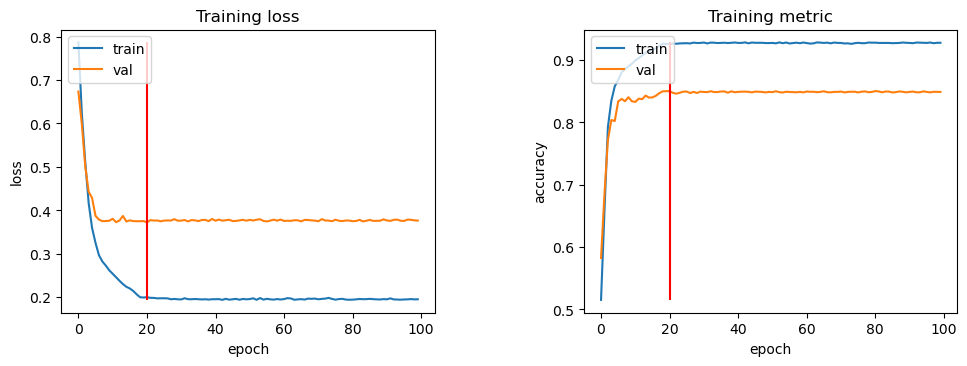

CPU times: total: 3min 32s
Wall time: 3min 33s


In [11]:
%%time
# train parent model B
modelB = train_early_stopping(model_name='B',
                              train_iter=train_iter,
                              valid_iter=valid_iter,
                              epochs=EPOCHS,
                              device=device,
                              lr=LEARNING_RATE)

# Model fusion

### (Optional) load models

In [5]:
# load parent models
modelA = new_model(embedding, pad_idx, voc_size, device) # init model
modelB = new_model(embedding, pad_idx, voc_size, device) # init model

modelA = torch.load('./Models/parallel_training/modelA_IMDB_256')
modelB = torch.load('./Models/parallel_training/modelB_IMDB_256')

modelA = modelA.to(device) # put on CPU/GPU
modelB = modelB.to(device) # put on CPU/GPU

### Fusion

Vanilla fusion

In [116]:
model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)

fusion successful


Optimal transport

In [59]:
model_fusion = ot_fusion(modelA, modelB, train_iter, embedding, pad_idx, voc_size, device, fusion_ratio=0.5)

fusion successful


### Test fusion

Randomly initialized model for comparison

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


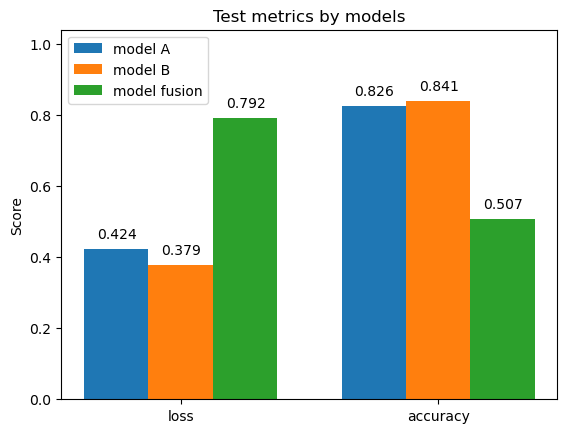

In [131]:
# test with new randomly initialized transformer
model_random = new_model(embedding, pad_idx, voc_size, device) # init model

test_fusion(modelA, modelB, model_random, test_iter, device)

Vanilla fusion model

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


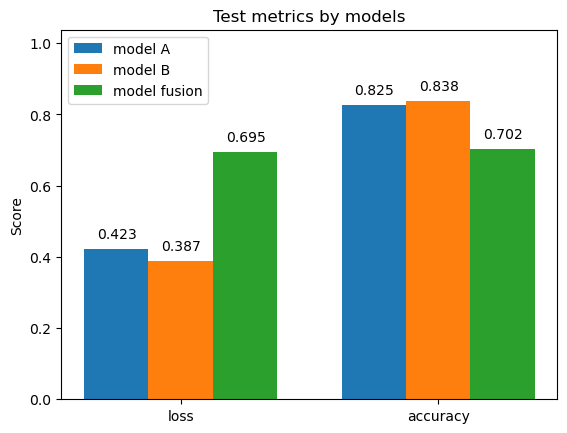

In [130]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion_vanilla, test_iter, device)

OT fusion model

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


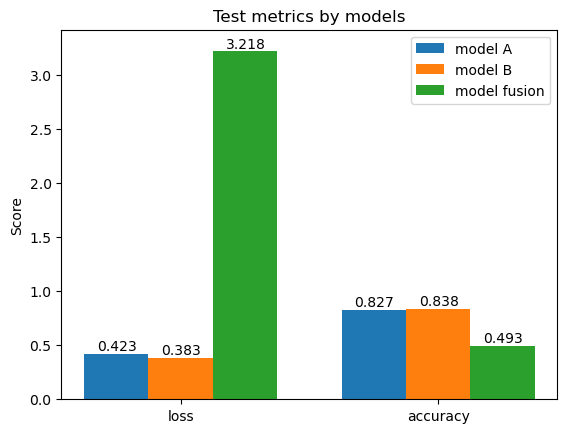

In [129]:
# test with OT fusion
test_fusion(modelA, modelB, model_fusion, test_iter, device)

### Retraining

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
100%|██████████| 47/47 [00:02<00:00, 23.28it/s]
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


Epoch: 1  Train Loss: 1.5753               Validation Loss: 2.8600               Train acc: 0.5500,               Val acc: 0.4959,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.66it/s]


Epoch: 2  Train Loss: 2.4358               Validation Loss: 2.4859               Train acc: 0.5065,               Val acc: 0.4963,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.50it/s]


Epoch: 3  Train Loss: 2.0776               Validation Loss: 2.1202               Train acc: 0.5078,               Val acc: 0.4984,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.50it/s]


Epoch: 4  Train Loss: 1.7173               Validation Loss: 1.7603               Train acc: 0.5151,               Val acc: 0.5067,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.94it/s]


Epoch: 5  Train Loss: 1.3856               Validation Loss: 1.4232               Train acc: 0.5293,               Val acc: 0.5289,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.25it/s]


Epoch: 6  Train Loss: 1.0747               Validation Loss: 1.1249               Train acc: 0.5631,               Val acc: 0.5654,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.57it/s]


Epoch: 7  Train Loss: 0.8117               Validation Loss: 0.8749               Train acc: 0.6227,               Val acc: 0.6230,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.97it/s]


Epoch: 8  Train Loss: 0.6038               Validation Loss: 0.6969               Train acc: 0.7042,               Val acc: 0.6919,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.90it/s]


Epoch: 9  Train Loss: 0.4634               Validation Loss: 0.5869               Train acc: 0.7851,               Val acc: 0.7298,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.42it/s]


Epoch: 10  Train Loss: 0.3984               Validation Loss: 0.5541               Train acc: 0.8302,               Val acc: 0.7423,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.00it/s]


Epoch: 11  Train Loss: 0.3821               Validation Loss: 0.5390               Train acc: 0.8354,               Val acc: 0.7504,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.33it/s]


Epoch: 12  Train Loss: 0.3686               Validation Loss: 0.5297               Train acc: 0.8436,               Val acc: 0.7530,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 23.67it/s]


Epoch: 13  Train Loss: 0.3603               Validation Loss: 0.5214               Train acc: 0.8485,               Val acc: 0.7559,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 23.56it/s]


Epoch: 14  Train Loss: 0.3561               Validation Loss: 0.5153               Train acc: 0.8515,               Val acc: 0.7593,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.31it/s]


Epoch: 15  Train Loss: 0.3515               Validation Loss: 0.5111               Train acc: 0.8547,               Val acc: 0.7595,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 23.78it/s]


Epoch: 16  Train Loss: 0.3467               Validation Loss: 0.5088               Train acc: 0.8579,               Val acc: 0.7612,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.42it/s]


Epoch: 17  Train Loss: 0.3434               Validation Loss: 0.5044               Train acc: 0.8608,               Val acc: 0.7627,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.08it/s]


Epoch: 18  Train Loss: 0.3390               Validation Loss: 0.5046               Train acc: 0.8632,               Val acc: 0.7659,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.20it/s]


Epoch: 19  Train Loss: 0.3390               Validation Loss: 0.5010               Train acc: 0.8646,               Val acc: 0.7662,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.08it/s]


Epoch: 20  Train Loss: 0.3383               Validation Loss: 0.4964               Train acc: 0.8648,               Val acc: 0.7679,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.44it/s]


Epoch: 21  Train Loss: 0.3345               Validation Loss: 0.4978               Train acc: 0.8673,               Val acc: 0.7663,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.32it/s]


Epoch: 22  Train Loss: 0.3332               Validation Loss: 0.4954               Train acc: 0.8703,               Val acc: 0.7644,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.32it/s]


Epoch: 23  Train Loss: 0.3313               Validation Loss: 0.4952               Train acc: 0.8710,               Val acc: 0.7654,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.39it/s]


Epoch: 24  Train Loss: 0.3308               Validation Loss: 0.4936               Train acc: 0.8715,               Val acc: 0.7661,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.30it/s]


Epoch: 25  Train Loss: 0.3304               Validation Loss: 0.4928               Train acc: 0.8718,               Val acc: 0.7656,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.39it/s]


Epoch: 26  Train Loss: 0.3281               Validation Loss: 0.4900               Train acc: 0.8741,               Val acc: 0.7689,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.02it/s]


Epoch: 27  Train Loss: 0.3281               Validation Loss: 0.4907               Train acc: 0.8736,               Val acc: 0.7683,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.20it/s]


Epoch: 28  Train Loss: 0.3275               Validation Loss: 0.4900               Train acc: 0.8738,               Val acc: 0.7687,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.36it/s]


Epoch: 29  Train Loss: 0.3277               Validation Loss: 0.4909               Train acc: 0.8734,               Val acc: 0.7672,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.42it/s]


Epoch: 30  Train Loss: 0.3272               Validation Loss: 0.4893               Train acc: 0.8740,               Val acc: 0.7688,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.10it/s]


Epoch: 31  Train Loss: 0.3257               Validation Loss: 0.4885               Train acc: 0.8746,               Val acc: 0.7703,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.19it/s]


Epoch: 32  Train Loss: 0.3254               Validation Loss: 0.4888               Train acc: 0.8753,               Val acc: 0.7686,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.40it/s]


Epoch: 33  Train Loss: 0.3251               Validation Loss: 0.4889               Train acc: 0.8754,               Val acc: 0.7697,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.40it/s]


Epoch: 34  Train Loss: 0.3252               Validation Loss: 0.4873               Train acc: 0.8765,               Val acc: 0.7703,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.04it/s]


Epoch: 35  Train Loss: 0.3236               Validation Loss: 0.4898               Train acc: 0.8769,               Val acc: 0.7698,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.25it/s]


Epoch: 36  Train Loss: 0.3242               Validation Loss: 0.4857               Train acc: 0.8760,               Val acc: 0.7721,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.37it/s]


Epoch: 37  Train Loss: 0.3234               Validation Loss: 0.4888               Train acc: 0.8772,               Val acc: 0.7700,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.45it/s]


Epoch: 38  Train Loss: 0.3223               Validation Loss: 0.4849               Train acc: 0.8774,               Val acc: 0.7719,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.23it/s]


Epoch: 39  Train Loss: 0.3226               Validation Loss: 0.4852               Train acc: 0.8771,               Val acc: 0.7722,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.15it/s]


Epoch: 40  Train Loss: 0.3223               Validation Loss: 0.4872               Train acc: 0.8771,               Val acc: 0.7699,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.36it/s]


Epoch: 41  Train Loss: 0.3209               Validation Loss: 0.4842               Train acc: 0.8779,               Val acc: 0.7741,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.32it/s]


Epoch: 42  Train Loss: 0.3217               Validation Loss: 0.4862               Train acc: 0.8775,               Val acc: 0.7734,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.20it/s]


Epoch: 43  Train Loss: 0.3222               Validation Loss: 0.4844               Train acc: 0.8771,               Val acc: 0.7742,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 23.94it/s]


Epoch: 44  Train Loss: 0.3218               Validation Loss: 0.4850               Train acc: 0.8776,               Val acc: 0.7748,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.30it/s]


Epoch: 45  Train Loss: 0.3210               Validation Loss: 0.4842               Train acc: 0.8784,               Val acc: 0.7758,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.33it/s]


Epoch: 46  Train Loss: 0.3202               Validation Loss: 0.4842               Train acc: 0.8786,               Val acc: 0.7742,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.00it/s]


Epoch: 47  Train Loss: 0.3194               Validation Loss: 0.4836               Train acc: 0.8801,               Val acc: 0.7743,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.13it/s]


Epoch: 48  Train Loss: 0.3191               Validation Loss: 0.4847               Train acc: 0.8796,               Val acc: 0.7743,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.38it/s]


Epoch: 49  Train Loss: 0.3191               Validation Loss: 0.4823               Train acc: 0.8793,               Val acc: 0.7767,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.26it/s]


Epoch: 50  Train Loss: 0.3192               Validation Loss: 0.4827               Train acc: 0.8800,               Val acc: 0.7751,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.11it/s]


Epoch: 51  Train Loss: 0.3188               Validation Loss: 0.4810               Train acc: 0.8792,               Val acc: 0.7762,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.20it/s]


Epoch: 52  Train Loss: 0.3179               Validation Loss: 0.4814               Train acc: 0.8798,               Val acc: 0.7772,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.44it/s]


Epoch: 53  Train Loss: 0.3181               Validation Loss: 0.4828               Train acc: 0.8806,               Val acc: 0.7763,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.33it/s]


Epoch: 54  Train Loss: 0.3170               Validation Loss: 0.4829               Train acc: 0.8804,               Val acc: 0.7752,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.18it/s]


Epoch: 55  Train Loss: 0.3174               Validation Loss: 0.4821               Train acc: 0.8799,               Val acc: 0.7751,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:02<00:00, 22.50it/s]


Epoch: 56  Train Loss: 0.3165               Validation Loss: 0.4825               Train acc: 0.8813,               Val acc: 0.7740,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:01<00:00, 24.53it/s]


Epoch: 57  Train Loss: 0.3165               Validation Loss: 0.4817               Train acc: 0.8809,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.50it/s]


Epoch: 58  Train Loss: 0.3177               Validation Loss: 0.4785               Train acc: 0.8807,               Val acc: 0.7773,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.29it/s]


Epoch: 59  Train Loss: 0.3171               Validation Loss: 0.4808               Train acc: 0.8804,               Val acc: 0.7759,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.92it/s]


Epoch: 60  Train Loss: 0.3160               Validation Loss: 0.4811               Train acc: 0.8809,               Val acc: 0.7764,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.95it/s]


Epoch: 61  Train Loss: 0.3159               Validation Loss: 0.4820               Train acc: 0.8812,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.32it/s]


Epoch: 62  Train Loss: 0.3156               Validation Loss: 0.4810               Train acc: 0.8818,               Val acc: 0.7756,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.40it/s]


Epoch: 63  Train Loss: 0.3162               Validation Loss: 0.4815               Train acc: 0.8807,               Val acc: 0.7761,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.94it/s]


Epoch: 64  Train Loss: 0.3151               Validation Loss: 0.4798               Train acc: 0.8815,               Val acc: 0.7765,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.38it/s]


Epoch: 65  Train Loss: 0.3156               Validation Loss: 0.4818               Train acc: 0.8813,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.35it/s]


Epoch: 66  Train Loss: 0.3178               Validation Loss: 0.4813               Train acc: 0.8809,               Val acc: 0.7759,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.28it/s]


Epoch: 67  Train Loss: 0.3157               Validation Loss: 0.4819               Train acc: 0.8817,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.05it/s]


Epoch: 68  Train Loss: 0.3156               Validation Loss: 0.4808               Train acc: 0.8818,               Val acc: 0.7761,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.31it/s]


Epoch: 69  Train Loss: 0.3159               Validation Loss: 0.4805               Train acc: 0.8818,               Val acc: 0.7758,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.37it/s]


Epoch: 70  Train Loss: 0.3161               Validation Loss: 0.4801               Train acc: 0.8809,               Val acc: 0.7758,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.28it/s]


Epoch: 71  Train Loss: 0.3152               Validation Loss: 0.4821               Train acc: 0.8820,               Val acc: 0.7753,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.26it/s]


Epoch: 72  Train Loss: 0.3165               Validation Loss: 0.4800               Train acc: 0.8812,               Val acc: 0.7768,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.57it/s]


Epoch: 73  Train Loss: 0.3157               Validation Loss: 0.4816               Train acc: 0.8816,               Val acc: 0.7761,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.44it/s]


Epoch: 74  Train Loss: 0.3153               Validation Loss: 0.4832               Train acc: 0.8818,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.38it/s]


Epoch: 75  Train Loss: 0.3162               Validation Loss: 0.4827               Train acc: 0.8809,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.13it/s]


Epoch: 76  Train Loss: 0.3177               Validation Loss: 0.4821               Train acc: 0.8801,               Val acc: 0.7752,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.31it/s]


Epoch: 77  Train Loss: 0.3159               Validation Loss: 0.4810               Train acc: 0.8816,               Val acc: 0.7755,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.32it/s]


Epoch: 78  Train Loss: 0.3153               Validation Loss: 0.4814               Train acc: 0.8825,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.34it/s]


Epoch: 79  Train Loss: 0.3174               Validation Loss: 0.4815               Train acc: 0.8805,               Val acc: 0.7758,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.16it/s]


Epoch: 80  Train Loss: 0.3147               Validation Loss: 0.4834               Train acc: 0.8822,               Val acc: 0.7749,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.24it/s]


Epoch: 81  Train Loss: 0.3166               Validation Loss: 0.4802               Train acc: 0.8809,               Val acc: 0.7763,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.35it/s]


Epoch: 82  Train Loss: 0.3154               Validation Loss: 0.4803               Train acc: 0.8822,               Val acc: 0.7770,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.27it/s]


Epoch: 83  Train Loss: 0.3161               Validation Loss: 0.4824               Train acc: 0.8812,               Val acc: 0.7752,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.21it/s]


Epoch: 84  Train Loss: 0.3158               Validation Loss: 0.4831               Train acc: 0.8816,               Val acc: 0.7750,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.33it/s]


Epoch: 85  Train Loss: 0.3161               Validation Loss: 0.4808               Train acc: 0.8812,               Val acc: 0.7752,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.38it/s]


Epoch: 86  Train Loss: 0.3166               Validation Loss: 0.4804               Train acc: 0.8809,               Val acc: 0.7753,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.50it/s]


Epoch: 87  Train Loss: 0.3154               Validation Loss: 0.4808               Train acc: 0.8820,               Val acc: 0.7762,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.04it/s]


Epoch: 88  Train Loss: 0.3165               Validation Loss: 0.4815               Train acc: 0.8803,               Val acc: 0.7757,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:02<00:00, 22.59it/s]


Epoch: 89  Train Loss: 0.3175               Validation Loss: 0.4798               Train acc: 0.8799,               Val acc: 0.7766,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.35it/s]


Epoch: 90  Train Loss: 0.3161               Validation Loss: 0.4806               Train acc: 0.8814,               Val acc: 0.7761,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.41it/s]


Epoch: 91  Train Loss: 0.3170               Validation Loss: 0.4813               Train acc: 0.8803,               Val acc: 0.7754,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.14it/s]


Epoch: 92  Train Loss: 0.3164               Validation Loss: 0.4797               Train acc: 0.8814,               Val acc: 0.7775,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.12it/s]


Epoch: 93  Train Loss: 0.3165               Validation Loss: 0.4818               Train acc: 0.8805,               Val acc: 0.7758,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.38it/s]


Epoch: 94  Train Loss: 0.3157               Validation Loss: 0.4811               Train acc: 0.8820,               Val acc: 0.7759,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 23.95it/s]


Epoch: 95  Train Loss: 0.3157               Validation Loss: 0.4803               Train acc: 0.8812,               Val acc: 0.7768,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.20it/s]


Epoch: 96  Train Loss: 0.3155               Validation Loss: 0.4799               Train acc: 0.8814,               Val acc: 0.7764,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.24it/s]


Epoch: 97  Train Loss: 0.3158               Validation Loss: 0.4809               Train acc: 0.8822,               Val acc: 0.7755,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.38it/s]


Epoch: 98  Train Loss: 0.3166               Validation Loss: 0.4817               Train acc: 0.8812,               Val acc: 0.7757,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.43it/s]


Epoch: 99  Train Loss: 0.3156               Validation Loss: 0.4812               Train acc: 0.8820,               Val acc: 0.7749,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:01<00:00, 24.10it/s]


Epoch: 100  Train Loss: 0.3160               Validation Loss: 0.4810               Train acc: 0.8816,               Val acc: 0.7753,               Learning Rate : 0.0000


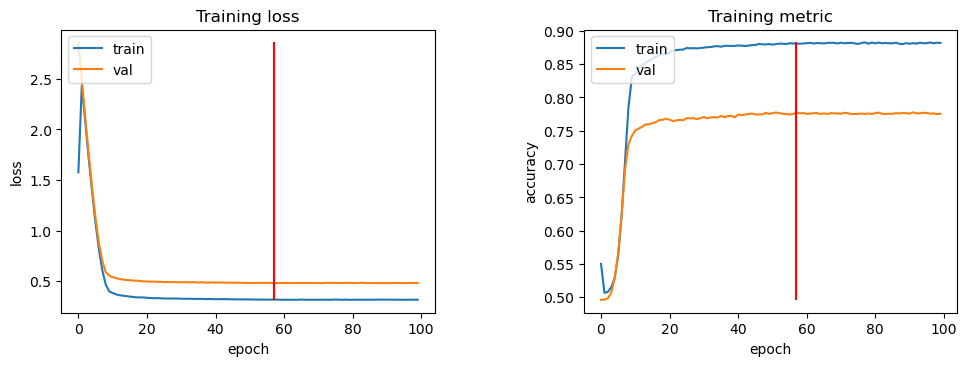

CPU times: total: 3min 26s
Wall time: 3min 26s


In [135]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=LEARNING_RATE)
loss_fn_fusion = nn.CrossEntropyLoss()

history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             valid_iter=valid_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=EPOCHS,
                                                                             clip=1,
                                                                             device=device)

In [137]:
model_name = 'fusion_OT_post_retraining'

In [138]:
# save model
name = f'parallel_training/model{model_name}_IMDB_256'
save_model(model_fusion, name=name)

# save history
name = f'parallel_training/history_model{model_name}_IMDB_256'
save_history(history_fusion, name=name)

In [141]:
# load best model (current model is trained on full epochs)
model_fusion = torch.load(f'Models/parallel_training/model{model_name}_IMDB_256')

### Test fusion (after retraining)

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


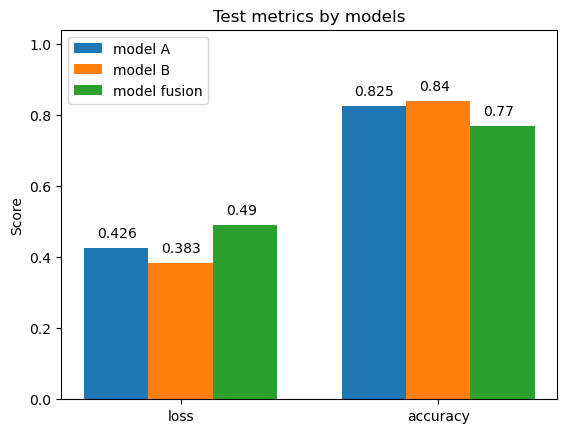

In [142]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion, test_iter, device)